In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import kaepora as kpora
import kaepora_plot as kplot
import spectral_analysis as sa
import uncertainties

In [19]:
#measures velocities of composites, bootstrapped composites, and individual SNe
#returns a mess of data :). 
def measure_vels(comps, sn_arrs, boot_arrs=None):
    avg_vs = []
    for comp in comps:
        v, si_min_wave = sa.measure_velocity(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], 5800, 6400, plot=False)
        avg_vs.append(v)
        print 'Composite Velocity: ', v
    
    errors = []
    boot_vel_arrs = []
    if boot_arrs:
        
        for boots in boot_arrs:
            b_vs = []
            for b in boots:
                v, si_min_wave = sa.measure_velocity(b.wavelength[b.x1:b.x2], b.flux[b.x1:b.x2], 5800, 6400, plot=False)
                if ~np.isnan(v) and v != None:
                    b_vs.append(v)
            boot_vel_arrs.append(b_vs)
            # errors.append(np.std(b_vs))
            plt.hist(b_vs)
            plt.show()
            
        low_errors = []
        up_errors = []
        for vlist in boot_vel_arrs:
            p = np.percentile(vlist, [18, 50, 82])
            vlower = p[1] - p[0]
            vupper = p[2] - p[1]
            low_errors.append(vupper)
            up_errors.append(vlower)

        errors = [low_errors, up_errors]
        
    avg_hrs = []
    for arr in sn_arrs:
        hr_list = []
        for i, spec in enumerate(arr):
            hr_list.append(spec.other_meta_data["MURES"])
        avg_hrs.append(np.average(hr_list))
    
    #Caveat: this includes combined spectra
    vels = []
    hrs = []
    hr_errs = []
    vel_errs = []
    names = []
    x1s = []
    cs = []
    sigint = 0.1165
    for arr in sn_arrs:
        for i, spec in enumerate(arr):
            v, si_min_wave, verror = sa.measure_velocity(spec.wavelength[spec.x1:spec.x2], spec.flux[spec.x1:spec.x2], 5800, 6300, plot=True, error=True)
            hrs.append(spec.other_meta_data["MURES"])
            hr_err = np.sqrt(spec.other_meta_data["MUERR"]**2. - sigint**2.)
            hr_errs.append(hr_err)
            vels.append(v)
            vel_errs.append(verror)
            names.append(spec.name)
            x1s.append(spec.other_meta_data["x1"])
            cs.append(spec.other_meta_data["c"])
            print i, spec.name
            print 'Velocity:', v, '+/-', verror, 'x1:', spec.other_meta_data["x1"], 'c:', spec.other_meta_data["c"], 'HR', spec.other_meta_data["MURES"], '+/-', hr_err
    
    return (boot_vel_arrs, avg_vs, avg_hrs, hrs, hr_errs, vels, errors, vel_errs), (names, x1s, cs)

In [41]:
#plots the results from the above function
def plot_vels(vel_data, savename=None):
    from matplotlib.ticker import NullFormatter
    from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
    boot_vel_arrs, avg_vs, avg_hrs, hrs, hr_errs, vels, errors, vel_errs = vel_data[0], vel_data[1], vel_data[2], vel_data[3], vel_data[4], vel_data[5], vel_data[6], vel_data[7]
        
    plt.rc('font', family='serif')
    plt.figure(num = 1, dpi = 100, figsize = [9,9])

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    axScatter = plt.axes(rect_scatter)

    plt.minorticks_on()
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    #     ax.get_yaxis().set_ticks([])
    #     plt.ylim([-311,12])
    plt.ylabel('Velocity ($10^3$ km s$^{-1}$)', fontsize = 20)
    plt.xlabel('Hubble Residual (mag)', fontsize = 20)
    plt.tick_params(
        which='major', 
        bottom='on', 
        top='on',
        left='on',
        right='on',
        direction='in',
        length=20)
    plt.tick_params(
        which='minor', 
        bottom='on', 
        top='on',
        left='on',
        right='on',
        direction='in',
        length=10)

    markers, caps, bars = axScatter.errorbar(hrs, vels, xerr=hr_errs, yerr=vel_errs, fmt='o', markersize=8, color = 'black', capsize=5, zorder=-10, label='Individual SNe')
    [bar.set_alpha(0.2) for bar in bars]
    if len(boot_vel_arrs)> 0:
        violin_parts = axScatter.violinplot(boot_vel_arrs, avg_hrs, points=40, widths=0.1,
                          showmeans=False, showextrema=False, showmedians=False,
                          bw_method='silverman')
        
    diff = avg_vs[1] - avg_vs[0]
    if len(errors)>0:
        err = np.sqrt(errors[0][0]**2. + errors[1][1]**2.)
    else:
        err = np.nan
    print 'Vdiff: ', diff, 'Err:', err, 'Sig: ', diff/err
    vdiff_unc = uncertainties.ufloat(diff, err)
    print vdiff_unc
    axScatter.errorbar(avg_hrs, avg_vs, fmt='*', markersize=20, color = 'orange', alpha=1., zorder=1, label= 'Composite \n Spectra')
#         vp = violin_parts['cmeans']
#         vp.set_edgecolor('darkblue')
#         vp.set_linewidth(4)
#         vp.set_alpha(1.)
    if len(boot_vel_arrs)> 0:
        for pc in violin_parts['bodies']:
            pc.set_facecolor('deepskyblue')
            pc.set_edgecolor('steelblue')
    #             pc.set_color('red')
            pc.set_alpha(.5)
    axScatter.set_xlim((-.57,.57))
    axScatter.axvline(x=0., linestyle = '--', color = 'deepskyblue', linewidth=3, alpha=.6)
    axScatter.text(-.45, -14.5, '+4 Days', fontsize=20)
    axScatter.legend(bbox_to_anchor=(0.48, 0.45, 0.48, 0.5), fontsize=15)
    plt.gca().invert_yaxis()

    axHistx = plt.axes(rect_histx)
    axHistx.legend(bbox_to_anchor=(0.48, 0.45, 0.48, 0.5), fontsize=5)
    plt.tick_params(
        which='major', 
        bottom='on', 
        top='on',
        left='on',
        right='on',
        direction='in',
        labelsize=15,
        length=10)
    plt.tick_params(
        which='minor', 
        bottom='on', 
        top='on',
        left='on',
        right='on',
        direction='in',
        length=5)
#         kplot.basic_format()
    axHisty = plt.axes(rect_histy)

    plt.tick_params(
        which='major', 
        bottom='on', 
        top='on',
        left='on',
        right='on',
        direction='in',
        labelsize=15,
        length=10)
    plt.tick_params(
        which='minor', 
        bottom='on', 
        top='on',
        left='on',
        right='on',
        direction='in',
        length=5)
#         kplot.basic_format()
    nullfmt = NullFormatter()
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    bins = np.linspace(-.4,.4,num=17,retstep = True)[0]
#         axHistx.hist(hrs, bins=bins)
    axHistx.hist(np.asarray(hrs)[np.asarray(vels) > -11], bins=bins, edgecolor='#000080', lw=1, color = '#000080', label = '$v > -11,000$ \n km s$^{-1}$', alpha=.5)
    axHistx.hist(np.asarray(hrs)[np.asarray(vels) < -11], bins=bins, edgecolor='#cc0000', lw=1, alpha=.5, color = '#cc0000', label = '$v < -11,000$ \n km s$^{-1}$')
    bins = np.linspace(-16,-9,num=15,retstep = True)[0]
#         axHisty.hist(vels, bins=bins, orientation='horizontal')
    axHisty.hist(np.asarray(vels)[np.asarray(hrs) > 0], bins=bins, edgecolor='#000080', lw=1, color = '#000080', label = 'HR > 0 mag', alpha=.5, orientation='horizontal')
    axHisty.hist(np.asarray(vels)[np.asarray(hrs) < 0], bins=bins, alpha=.5, edgecolor='#cc0000', lw=1, color = '#cc0000', label = 'HR < 0 mag', orientation='horizontal')

    majorLocator = MultipleLocator(5)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(1)
    axHisty.xaxis.set_major_locator(majorLocator)
    axHisty.xaxis.set_major_formatter(majorFormatter)
    axHisty.xaxis.set_minor_locator(minorLocator)

    plt.gca().invert_yaxis()
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    axHistx.legend(bbox_to_anchor=(0.01, 0.44, 0.48, 0.5), fontsize=12, frameon=False)
    axHisty.legend(bbox_to_anchor=(0.01, 0.44, 0.48, 0.5), fontsize=12, frameon=False)
    axHistx.set_yticks([0,2,4,6,8])
    axHistx.set_yticks([1,3,5,7], minor=True)
#         axHisty.set_xticks([0,5,10,15])
#         axHisty.set_xticks([2.5,7.5,12.5], minor=True)

    axHistx.set_ylabel('Number', fontsize=20)
    axHisty.set_xlabel('Number', fontsize=20)

    if savename is not None:
        plt.savefig(savename+'.pdf', dpi = 300, bbox_inches = 'tight')
        plt.savefig(savename+'.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

# Queries kaepora and generates composite spectra

In [43]:
hub_queries_p4 = ["SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase between 2 and 7 and Hubble_Res < 0 and ((dm15_source >= .7 and dm15_source < 1.8) or (dm15_from_fits >= .7 and dm15_from_fits < 1.8))",
                  "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase between 2 and 7 and Hubble_Res > 0 and ((dm15_source >= .7 and dm15_source < 1.8) or (dm15_from_fits >= .7 and dm15_from_fits < 1.8))"]

In [44]:
composites_p4, sn_arrays_p4, og_sn_arrays, boot_sn_arrays_p4 = kpora.make_composite(hub_queries_p4, boot=True, nboots=100, medmean=1, get_og_arr=True, verbose=False, gini_balance=True, combine=True)


SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase between 2 and 7 and Hubble_Res < 0 and ((dm15_source >= .7 and dm15_source < 1.8) or (dm15_from_fits >= .7 and dm15_from_fits < 1.8))
99 Total Spectra found
5 flagged spectra removed 94 spectra left
0 spectra of peculiar Ias removed 94 spectra left
88 spectra of SNe that have host reddening corrections
Arrays cleaned
88 spectra may have telluric contamination
30 total SNe
removed spectra of SNe with A_V > 2.0
Using 88 spectra of 30 SNe
Gini balancing...
Balanced after 4 iterations
Bootstrapping
scaling boots...
computing confidence intervals...
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase between 2 and 7 and Hubble_Res > 0 and ((dm15_source >= .7 and dm15_source < 1.8) or (dm15_from_fits >= .7 and dm15_from_fits < 1.8))
71 Total Spectra found
2 flagged spectra removed 69 spectra left
0 spectra of peculiar Ias removed 69 spectra left
65 spectra of SNe that

# Measures "+4-day" velocities of each SN

Composite Velocity:  -11.584409672466169
Composite Velocity:  -10.606676809804412


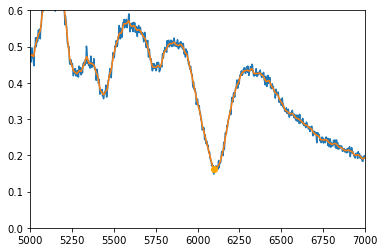

0 1994m_combined
Velocity: -12.270581404388267 +/- 0.12287051814218014 x1: -1.43321 c: 0.0653551 HR -0.1644 +/- 0.09778629760861184


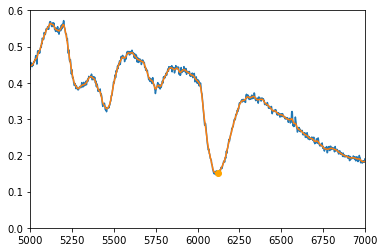

1 2003it_combined
Velocity: -11.290779369257717 +/- 0.0724135660219217 x1: -1.59553 c: 0.0485026 HR -0.0661 +/- 0.10613910683626462


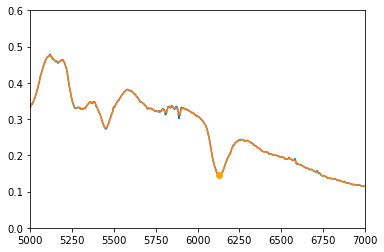

2 1999dq_combined
Velocity: -10.801986823599174 +/- 0.07621493437399353 x1: 0.8703 c: 0.0330588 HR -0.2163 +/- 0.15085128438299752


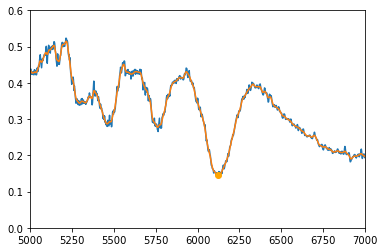

3 2002eu_combined
Velocity: -11.192961724806997 +/- 0.039115231608480634 x1: -2.06574 c: 0.0689389 HR -0.1631 +/- 0.1735187309773789


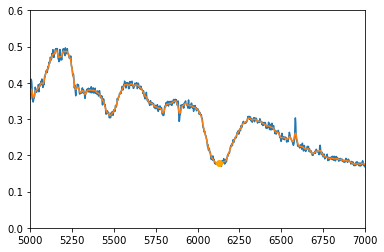

4 2008c_combined
Velocity: -10.997415134434632 +/- 0.04981802709867704 x1: -0.725556 c: 0.1156 HR -0.0857 +/- 0.12394256734471817


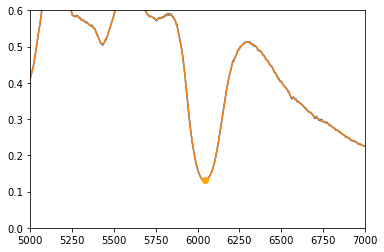

5 2002bf_combined
Velocity: -15.128702271077849 +/- 0.048676113159460625 x1: -2.29628 c: -0.0958711 HR -0.1055 +/- 0.15097761423469375


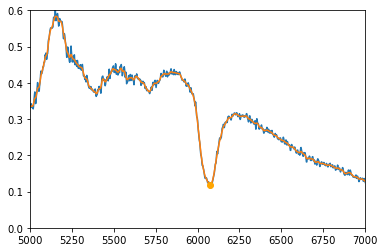

6 2006is_combined
Velocity: -13.548739780235412 +/- 0.08317354140109699 x1: 2.4433 c: -0.0667162 HR -0.0704 +/- 0.106287534546625


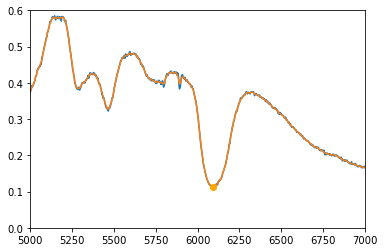

7 2001en_combined
Velocity: -12.565098143327868 +/- 0.08331520946911851 x1: -1.12549 c: 0.0547637 HR -0.1555 +/- 0.13484431764075192


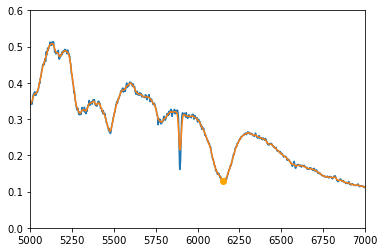

8 2006et_combined
Velocity: -9.631901785684354 +/- 0.05855636779076698 x1: 0.7568 c: 0.1423 HR -0.196 +/- 0.09224808941110924


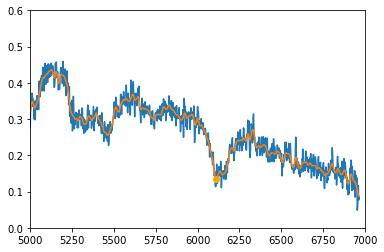

9 2007ae_combined
Velocity: -11.780310993061766 +/- 0.41919567425276594 x1: 1.6353 c: 0.00982209 HR -0.1917 +/- 0.06580417919858891


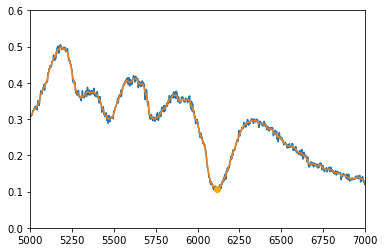

10 2004ef_combined
Velocity: -11.486503345380463 +/- 0.0593483147425003 x1: -1.40156 c: 0.0836825 HR -0.0599 +/- 0.07582051173660069


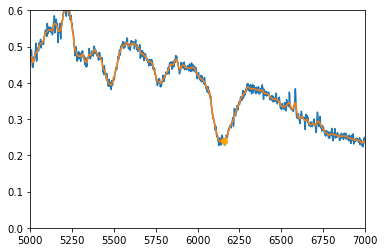

11 2004l_combined
Velocity: -9.340046364602408 +/- 0.20364828148575068 x1: -1.14613 c: 0.1985 HR -0.1003 +/- 0.09902605717688653


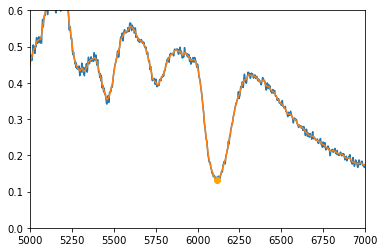

12 2007nq_combined
Velocity: -11.486503345380463 +/- 1.7763568394002505e-15 x1: -1.7092 c: -0.0489299 HR -0.0319 +/- 0.061421820227017046


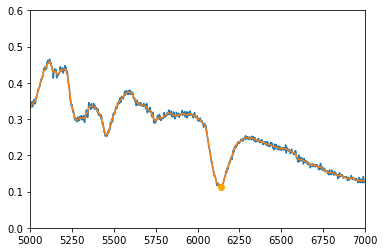

13 2005na_combined
Velocity: -10.313933633529203 +/- 0.07521169341239854 x1: -0.415475 c: -0.0281352 HR -0.1206 +/- 0.09176404524649072


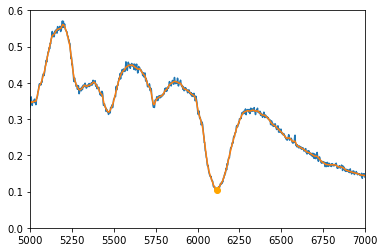

14 2007co_combined
Velocity: -11.584409672466169 +/- 0.07126705673457906 x1: -1.43321 c: 0.0653551 HR -0.1644 +/- 0.09778629760861184


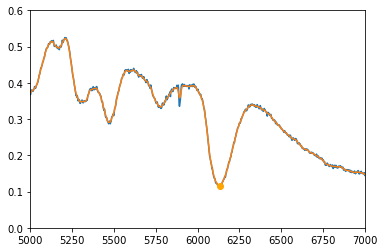

15 1997y_combined
Velocity: -10.704317028490788 +/- 0.04883489755419302 x1: -1.07426 c: 0.00814199 HR -0.1024 +/- 0.12394256734471817


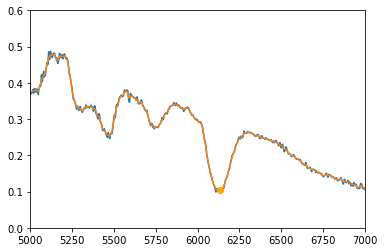

16 1998dx_combined
Velocity: -10.50906616967564 +/- 0.11006183902175977 x1: -1.58763 c: -0.0968185 HR -0.1772 +/- 0.07582051173660069


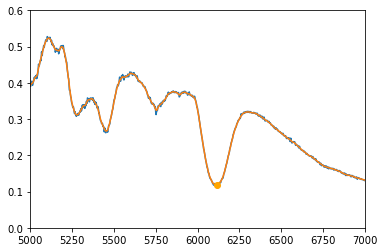

17 2006sr_combined
Velocity: -11.584409672466169 +/- 0.021344630921811714 x1: -1.4246 c: 0.0111358 HR -0.0246 +/- 0.09979634261835452


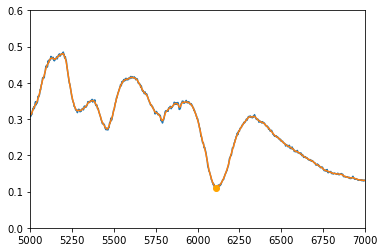

18 2001da_combined
Velocity: -11.780310993061766 +/- 0.1239261431594543 x1: -0.715734 c: 0.1027 HR -0.1364 +/- 0.15324490203592417


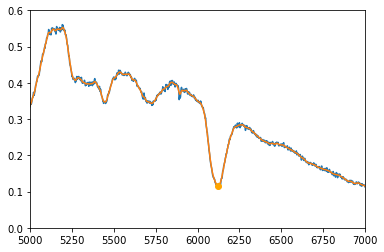

19 2001fe_combined
Velocity: -11.290779369257717 +/- 0.044825675999769915 x1: 0.6159 c: -0.0200103 HR -0.0735 +/- 0.12612945730478664


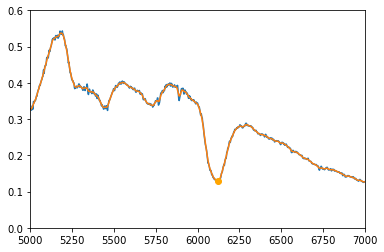

20 2000fa_combined
Velocity: -11.192961724806997 +/- 0.10400361944655447 x1: 0.4862 c: 0.0543856 HR -0.1055 +/- 0.10086902398655395


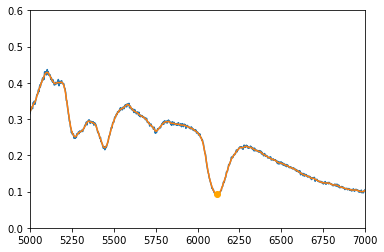

21 2008bf_combined
Velocity: -11.388626576876426 +/- 0.042932102356876646 x1: 0.3072 c: -0.0198939 HR -0.2085 +/- 0.09400978672457458


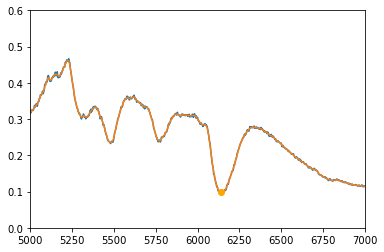

22 2007bc_combined
Velocity: -10.216411741678657 +/- 0.09292829148339468 x1: -1.17244 c: 0.0430286 HR -0.0708 +/- 0.10314606148564276


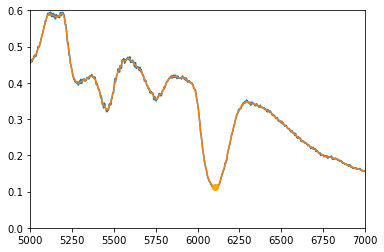

23 2002he_combined
Velocity: -12.07438460450608 +/- 1.7763568394002505e-15 x1: -1.83266 c: -0.0295058 HR -0.0092 +/- 0.1017832992194692


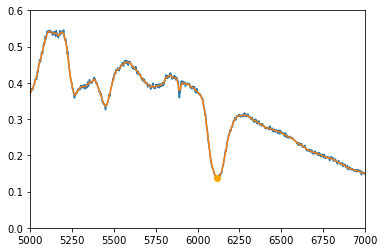

24 2001g
Velocity: -11.584409672466169 +/- 0.07670786519983773 x1: 0.2139 c: -0.0300653 HR -0.1641 +/- 0.13510851194502885


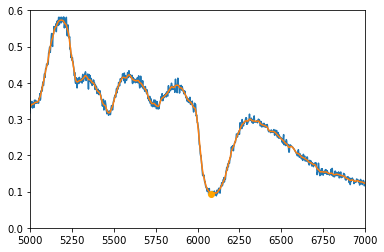

25 2006ac
Velocity: -13.15492891074885 +/- 0.2195186936945322 x1: -1.03034 c: 0.0473401 HR -0.0737 +/- 0.09794176841368547


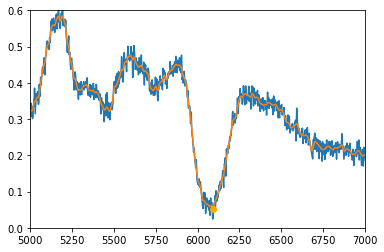

26 2006bq
Velocity: -12.761590299337318 +/- 0.29000067783730354 x1: -1.70555 c: 0.0632346 HR -0.0013 +/- 0.10284410532451532


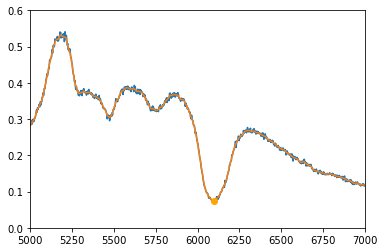

27 2006cp
Velocity: -12.466896361799964 +/- 0.06609566179394821 x1: 0.3595 c: 0.080036 HR -0.0473 +/- 0.10284410532451532


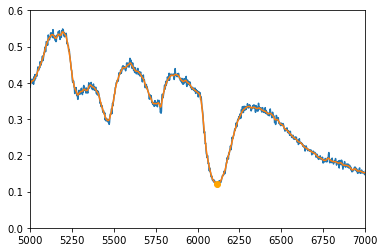

28 2008l
Velocity: -11.486503345380463 +/- 0.04830791174948804 x1: -1.68199 c: -0.0965636 HR -0.026 +/- 0.13338725576306007


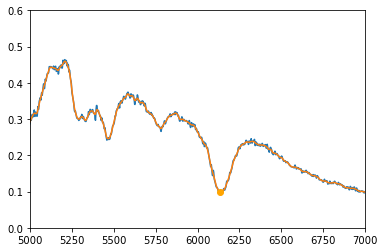

29 2008bq
Velocity: -10.50906616967564 +/- 0.06964839761748856 x1: 0.3554 c: 0.0534826 HR -0.0614 +/- 0.0778187638041109


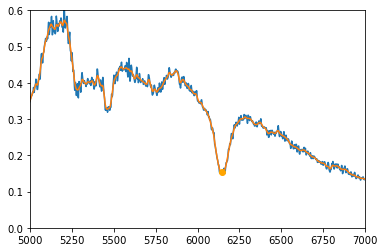

0 2005eq_combined
Velocity: -10.118919436719901 +/- 0.05846460984079962 x1: 1.2734 c: 0.0126785 HR 0.1457 +/- 0.07745811771531759


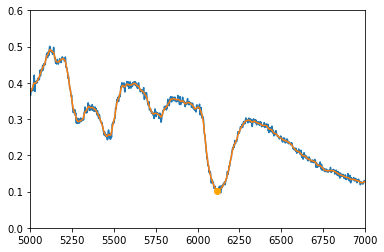

1 2002kf_combined
Velocity: -11.388626576876426 +/- 0.11766153954809284 x1: -1.15153 c: -0.0325287 HR 0.135 +/- 0.11371714910249904


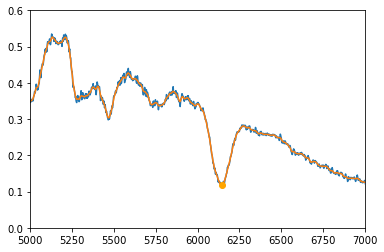

2 2002ck_combined
Velocity: -10.118919436719901 +/- 0.04618295999254257 x1: 0.1322 c: -0.0283628 HR 0.0037 +/- 0.08816439190512235


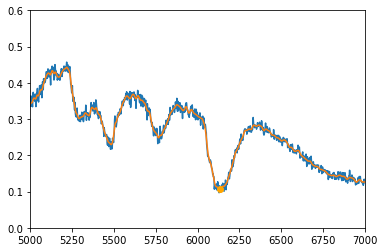

3 2003iv_combined
Velocity: -10.704317028490788 +/- 0.11879472663860521 x1: -2.10562 c: -0.0552041 HR 0.1046 +/- 0.09321153362111363


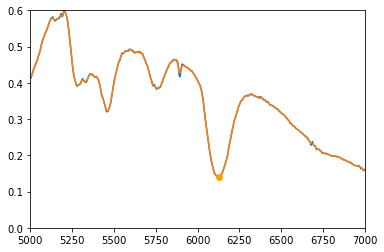

4 2003ch_combined
Velocity: -10.899686192972935 +/- 0.04891753987481434 x1: -1.30453 c: -0.0154138 HR 0.1502 +/- 0.09273057748121705


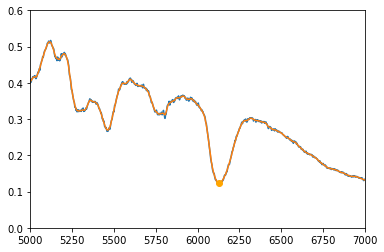

5 2005el_combined
Velocity: -10.899686192972935 +/- 0.07651952188267934 x1: -1.35488 c: -0.135924 HR 0.0307 +/- 0.13178983268826164


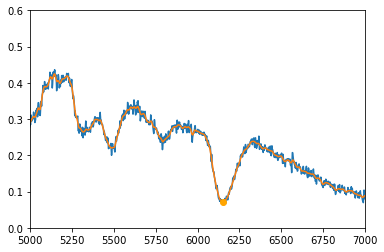

6 2000cf_combined
Velocity: -9.729246126124085 +/- 0.06231760432905771 x1: -0.521629 c: -0.0245362 HR 0.0934 +/- 0.07545323054714093


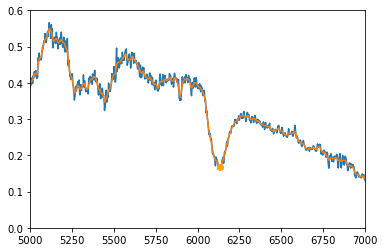

7 2006cj_combined
Velocity: -10.606676809804412 +/- 0.04626703863324047 x1: 2.1201 c: -0.0694886 HR 0.2135 +/- 0.08964792245222415


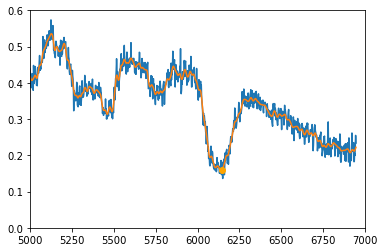

8 2006al_combined
Velocity: -10.118919436719901 +/- 0.24735380126734874 x1: -1.40139 c: -0.0910073 HR 0.1328 +/- 0.06997542425737766


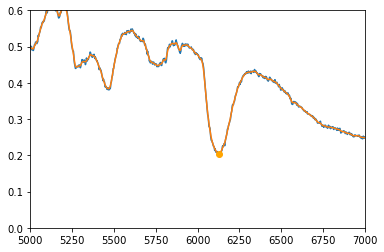

9 2006n_combined
Velocity: -10.899686192972935 +/- 0.03286657865540971 x1: -2.06224 c: -0.0271886 HR 0.1099 +/- 0.14229181283545445


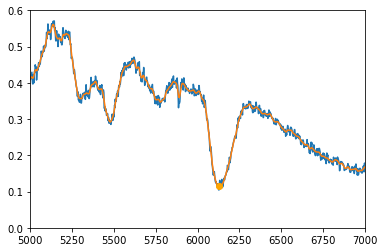

10 1998eg_combined
Velocity: -10.997415134434632 +/- 0.15194071256930244 x1: -0.489371 c: 0.0165965 HR 0.072 +/- 0.1016312451955598


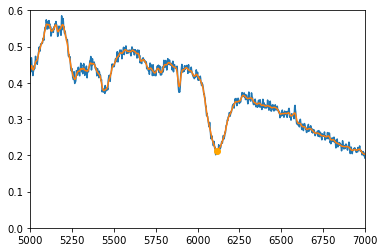

11 2002de_combined
Velocity: -11.584409672466169 +/- 0.0986717315467988 x1: 0.4583 c: 0.1152 HR 0.251 +/- 0.09918039120713328


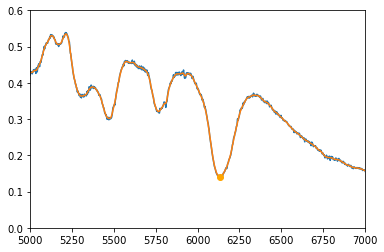

12 1999ej_combined
Velocity: -10.606676809804412 +/- 0.09225038075051359 x1: -1.51682 c: -0.0151465 HR 0.2033 +/- 0.14190387591605805


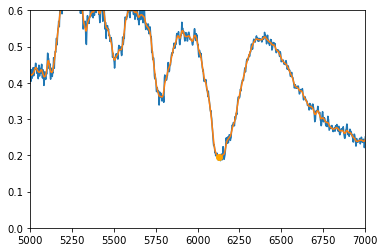

13 2005mc_combined
Velocity: -10.801986823599174 +/- 0.12635763052562352 x1: -2.6748 c: 0.2355 HR 0.0105 +/- 0.09979634261835452


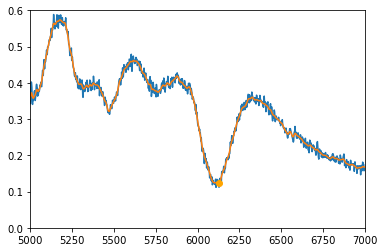

14 2004as_combined
Velocity: -10.997415134434632 +/- 0.15742740621200405 x1: 0.4069 c: 0.033411 HR 0.1877 +/- 0.0864971675836845


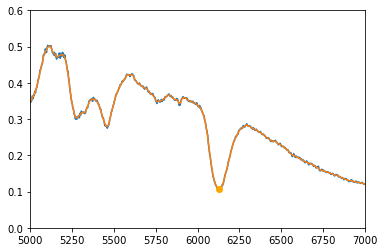

15 2007f_combined
Velocity: -10.899686192972935 +/- 0.04386690805205838 x1: 0.5366 c: -0.0388074 HR 0.0844 +/- 0.09369098142297368


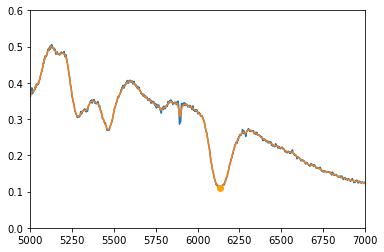

16 2007ca_combined
Velocity: -10.606676809804412 +/- 0.054204538938213254 x1: 0.5922 c: 0.2322 HR 0.3564 +/- 0.13629468074726905


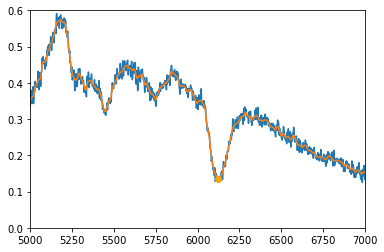

17 2005hc_combined
Velocity: -11.095173645785795 +/- 0.034568900724349184 x1: 0.425 c: -0.00579479 HR 0.0874 +/- 0.051064566971629165


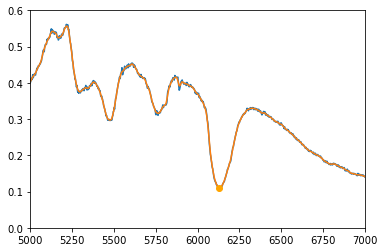

18 2002ha_combined
Velocity: -10.899686192972935 +/- 0.08526013250272563 x1: -1.37578 c: -0.0467151 HR 0.1265 +/- 0.1557497993578162


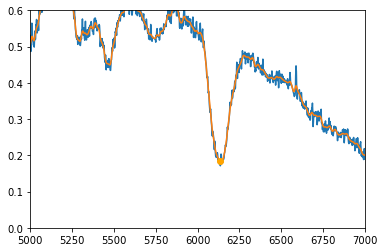

19 1996c
Velocity: -10.704317028490788 +/- 0.04681346705925181 x1: 0.6374 c: 0.0700634 HR 0.2193 +/- 0.095909123653592


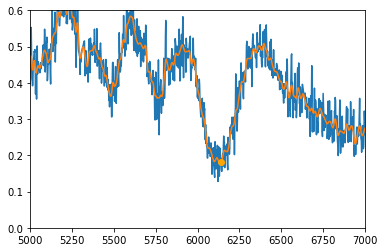

20 2006eq
Velocity: -10.313933633529203 +/- 0.27987896962721925 x1: -2.083 c: 0.0969351 HR 0.1694 +/- 0.07471485796011391


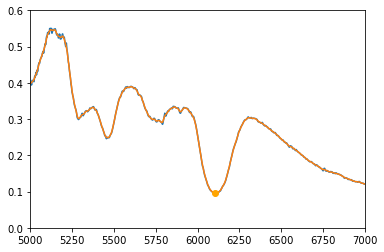

21 2006ef
Velocity: -11.976330519809686 +/- 0.04244587003007729 x1: -1.4594 c: -0.0161034 HR 0.0752 +/- 0.12421690706180057


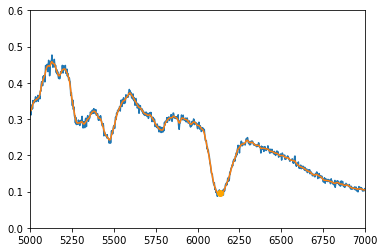

22 2007a
Velocity: -10.606676809804412 +/- 0.08108784067267512 x1: 0.4613 c: 0.1211 HR 0.2666 +/- 0.12007097900825162


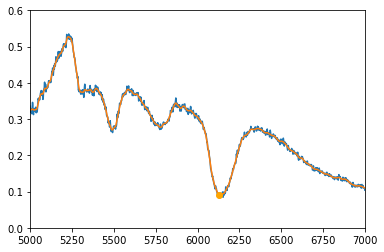

23 2002dp
Velocity: -10.899686192972935 +/- 0.16957892813358766 x1: -0.279289 c: 0.095423 HR 0.1414 +/- 0.18626819374224898


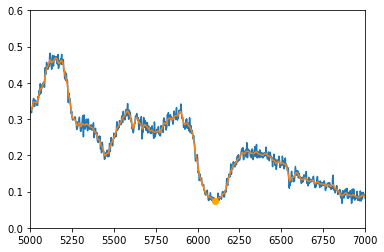

24 1993ac
Velocity: -11.976330519809686 +/- 0.028061290575284097 x1: -0.902764 c: 0.0258872 HR 0.0106 +/- 0.08066374650361832


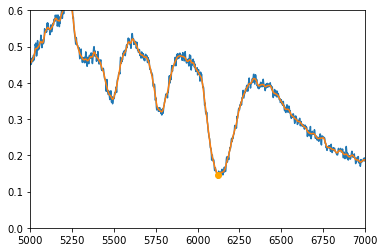

25 2000dk
Velocity: -11.095173645785795 +/- 0.15875627628951555 x1: -2.0428 c: -0.015223 HR 0.0016 +/- 0.12708072237755025


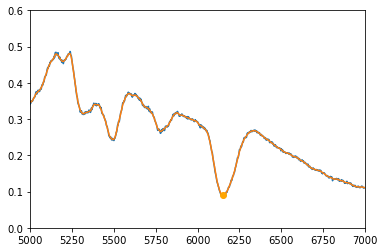

26 2002cr
Velocity: -9.826620063406793 +/- 0.1013018162448378 x1: -0.506246 c: -0.0164778 HR 0.0671 +/- 0.18756436228665616


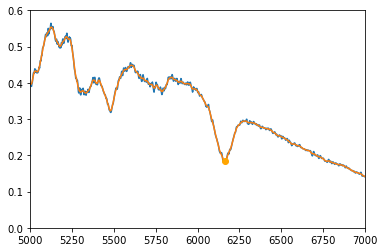

27 2006mp
Velocity: -9.145624102899788 +/- 0.013607485879649666 x1: 0.9113 c: 0.0245584 HR 0.1969 +/- 0.10389879691315004


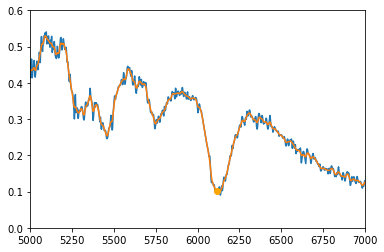

28 2002bz
Velocity: -11.486503345380463 +/- 0.14722080255656686 x1: -1.17993 c: -0.111899 HR 0.0426 +/- 0.10643584922383997


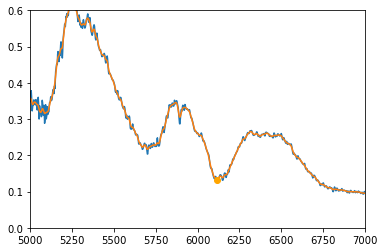

29 2006or
Velocity: -11.388626576876426 +/- 0.3035194362644324 x1: -1.21636 c: 0.21 HR 0.3434 +/- 0.12284233797840223


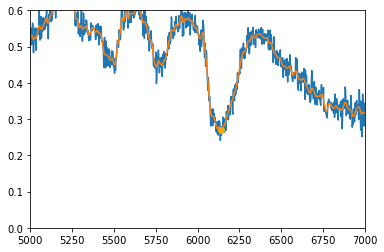

30 2006mo
Velocity: -10.313933633529203 +/- 0.1160002481867299 x1: -2.20453 c: 0.0380229 HR 0.0879 +/- 0.08783256799160548


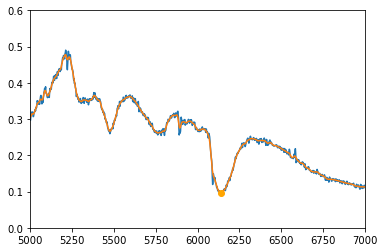

31 2005kc
Velocity: -10.313933633529203 +/- 0.09389854128199887 x1: -0.725132 c: 0.177 HR 0.023 +/- 0.13682046630530098


In [20]:
vel_data, other_data = measure_vels(composites_p4, sn_arrays_p4, boot_arrs=None)
# vel_data, other_data = measure_vels(composites_p4, sn_arrays_p4, boot_arrs=boot_sn_arrays_p4)

# Prints relevant measurements and data for the figure

In [32]:
print 'Num', 'SN', 'Vel', 'Vel_err', 'HR', 'HR_err', 'x1', 'c'
for i, sn in enumerate(other_data[0]):
    print i, sn.split('_')[0], round(vel_data[5][i],2), round(vel_data[7][i],2), 
    print vel_data[3][i], round(vel_data[4][i], 4), other_data[1][i], other_data[2][i]
    

Num SN Vel Vel_err HR HR_err x1 c
0 1994m -12.27 0.12 -0.1644 0.0978 -1.43321 0.0653551
1 2003it -11.29 0.07 -0.0661 0.1061 -1.59553 0.0485026
2 1999dq -10.8 0.08 -0.2163 0.1509 0.8703 0.0330588
3 2002eu -11.19 0.04 -0.1631 0.1735 -2.06574 0.0689389
4 2008c -11.0 0.05 -0.0857 0.1239 -0.725556 0.1156
5 2002bf -15.13 0.05 -0.1055 0.151 -2.29628 -0.0958711
6 2006is -13.55 0.08 -0.0704 0.1063 2.4433 -0.0667162
7 2001en -12.57 0.08 -0.1555 0.1348 -1.12549 0.0547637
8 2006et -9.63 0.06 -0.196 0.0922 0.7568 0.1423
9 2007ae -11.78 0.42 -0.1917 0.0658 1.6353 0.00982209
10 2004ef -11.49 0.06 -0.0599 0.0758 -1.40156 0.0836825
11 2004l -9.34 0.2 -0.1003 0.099 -1.14613 0.1985
12 2007nq -11.49 0.0 -0.0319 0.0614 -1.7092 -0.0489299
13 2005na -10.31 0.08 -0.1206 0.0918 -0.415475 -0.0281352
14 2007co -11.58 0.07 -0.1644 0.0978 -1.43321 0.0653551
15 1997y -10.7 0.05 -0.1024 0.1239 -1.07426 0.00814199
16 1998dx -10.51 0.11 -0.1772 0.0758 -1.58763 -0.0968185
17 2006sr -11.58 0.02 -0.0246 0.0998 -1.4246 0.

Vdiff:  0.9777328626617567 Err: nan Sig:  nan
0.977732862662+/-nan


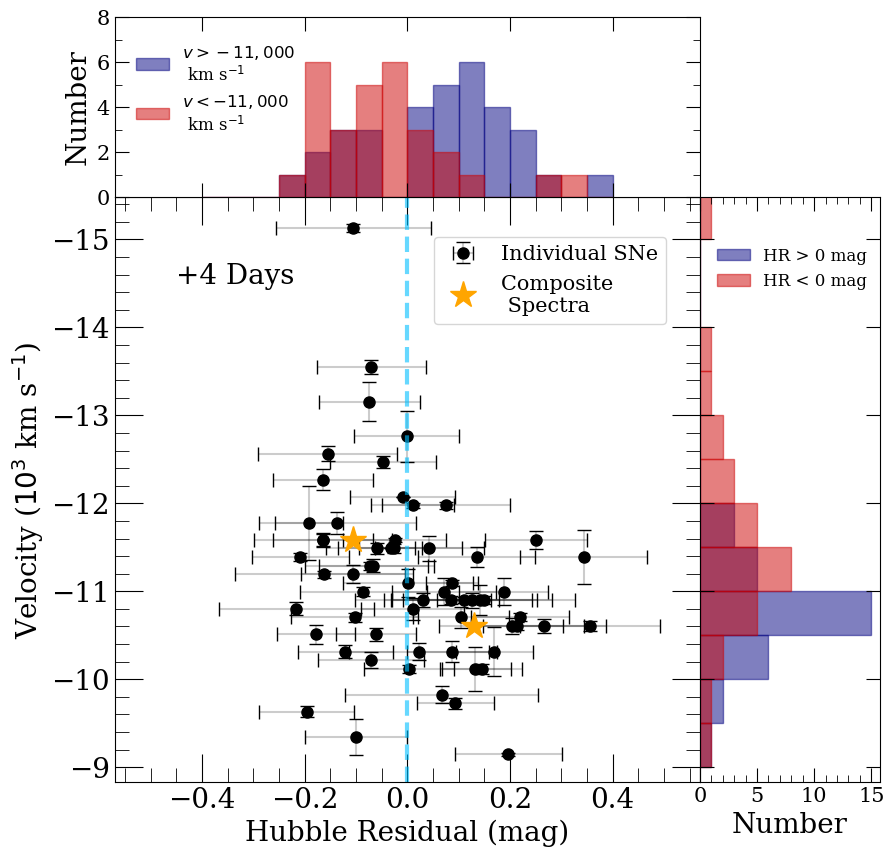

In [42]:
plot_vels(vel_data)